In [3]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr # you might need to install this (see above)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [4]:
stock_prices = pdr.get_data_yahoo(['AAPL','MSFT','VZ'], start=2006)
stock_prices = stock_prices.filter(like='Adj Close') # reduce to just columns with this in the name
stock_prices.columns = ['AAPL','MSFT','VZ']

daily_pct_change = pd.DataFrame()
for stock in ['AAPL','MSFT','VZ']:
    daily_pct_change[stock] = stock_prices[stock].pct_change() 

print(daily_pct_change.describe())

              AAPL         MSFT           VZ
count  3538.000000  3538.000000  3538.000000
mean      0.001199     0.000740     0.000507
std       0.019974     0.016697     0.013004
min      -0.179195    -0.117131    -0.080686
25%      -0.008068    -0.007076    -0.006231
50%       0.000956     0.000467     0.000704
75%       0.011254     0.008470     0.007193
max       0.139049     0.186047     0.146324


C:\Users\Juan Gabriel\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Juan Gabriel\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


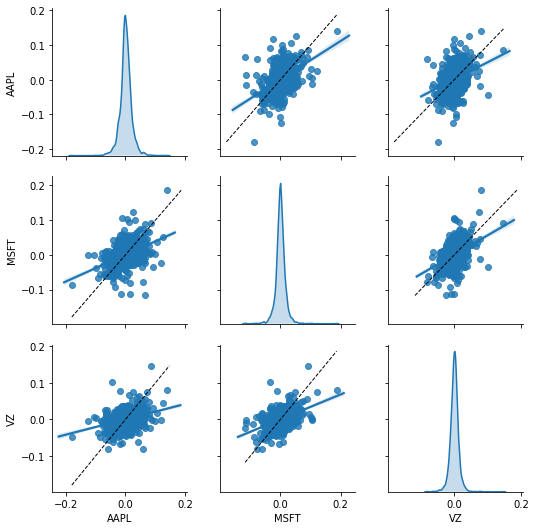

In [5]:
# we need this helper function for a plot

def plot_unity(xdata, ydata, **kwargs):
    '''
    Adds a 45 degree line to the pairplot for plots off the diagonal
    
    Usage: 
    grid=sns.pairplot( <call pairplot as you want >  )
    grid.map_offdiag(plot_unity)
    '''
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)
     
# compare the return distribution of 3 firms visually...
    
grid = sns.pairplot(daily_pct_change,diag_kind='kde',kind="reg")
grid.map_offdiag(plot_unity) # how cool is that!

In [6]:
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=2006)[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True) # cleaner name
ff = ff.join(daily_pct_change,how='inner') # merge with stock returns
for stock in ['MSFT','AAPL','VZ']:    
    ff[stock] = ff[stock] * 100 # FF store variables as percents, so convert to that
    ff[stock+'_excess'] = ff[stock] - ff['RF'] # convert to excess returns in prep for regressions
#print(ff.describe()) # ugly...
pd.set_option('display.float_format', lambda x: '%.2f' % x) # show fewer digits
pd.options.display.max_columns = ff.shape[1] # show more columns
print(ff.describe(include = 'all')) # better!

       mkt_excess     SMB     HML     RMW     CMA      RF    AAPL    MSFT  \
count     3523.00 3523.00 3523.00 3523.00 3523.00 3523.00 3522.00 3522.00   
mean         0.04    0.00   -0.01    0.01    0.00    0.00    0.12    0.07   
std          1.19    0.57    0.66    0.36    0.31    0.01    2.00    1.67   
min         -8.95   -3.40   -4.24   -2.62   -1.74    0.00  -17.92  -11.71   
25%         -0.40   -0.33   -0.31   -0.19   -0.18    0.00   -0.81   -0.71   
50%          0.08    0.00   -0.03    0.01   -0.01    0.00    0.09    0.05   
75%          0.56    0.33    0.26    0.21    0.17    0.01    1.12    0.85   
max         11.35    4.49    4.83    1.95    1.96    0.02   13.90   18.60   

           VZ  MSFT_excess  AAPL_excess  VZ_excess  
count 3522.00      3522.00      3522.00    3522.00  
mean     0.05         0.07         0.11       0.05  
std      1.30         1.67         2.00       1.30  
min     -8.07       -11.71       -17.93      -8.07  
25%     -0.63        -0.71        -0.82  

In [7]:
# run the models- 
params=pd.DataFrame()
for stock in ['MSFT','AAPL','VZ']:        
    print('\n\n\n','='*40,'\n',stock,'\n','='*40,'\n')
    model = sm.formula.ols(formula = stock+"_excess ~ mkt_excess + SMB + HML", data = ff).fit()
    print(model.summary())
    params[stock] = model.params.tolist()
params.set_index(model.params.index,inplace=True)   




 MSFT 

                            OLS Regression Results                            
Dep. Variable:            MSFT_excess   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     1341.
Date:                Sun, 26 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:11:46   Log-Likelihood:                -5464.8
No. Observations:                3522   AIC:                         1.094e+04
Df Residuals:                    3518   BIC:                         1.096e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0240      0.019      1.2

In [8]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) # show fewer digits
print(params)

              MSFT    AAPL      VZ
Intercept   0.0240  0.0693  0.0212
mkt_excess  1.1044  1.0967  0.6923
SMB        -0.3962 -0.1298 -0.3489
HML        -0.4469 -0.4249  0.0800


C:\Users\Juan Gabriel\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


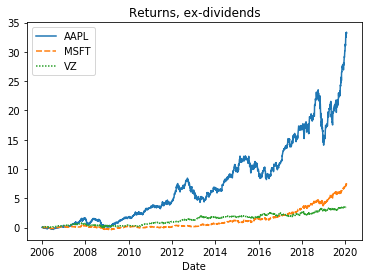

In [9]:
cumrets=(daily_pct_change+1).cumprod()-1
plt.clf() # clear the prior plot before starting a new one
sns.lineplot(data=cumrets).set_title("Returns, ex-dividends")
plt.show(grid)